In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from activ.analytics import heatmap
from activ.clustering import UmapClusteringResults
from os.path import dirname, join
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

In [26]:
f = h5py.File('/Users/ahyeon/Desktop/activ misc/predict_scores2.h5', 'r')

In [27]:
predictions = f['score'][:]
norm_predictions = f['norm_score'][:]
labels = f['clusters'][:]
umap_dims = f['umap_dimensions'][:]
cluster_sizes = f['cluster_sizes'][:]

In [28]:
def conf_alliter(size, predicted, actual):
    confalliter = []
    for j in range(50):
        conf = np.zeros((size,size))
        labs = list(map(int, actual[j][size-2]))
        preds = list(map(int, predicted[j][size-2]))
        for l, p in zip(labs, preds):
            conf[l,p] += 1
        confalliter.append(conf)
    return confalliter

In [29]:
def statistics(matrix):
    mat = np.matrix(matrix)
    i = mat.shape[0]-2
    tp = mat[i,i]
    tn = mat.sum() - mat[i,:].sum() - mat[:,i].sum() + mat[i,i]
    fp = mat[:,i].sum() - mat[i,i]
    fn = mat[i,:].sum() - mat[i,i]
    return tp, tn, fp, fn

In [34]:
def avg_statistics(matrix):
    mat = np.matrix(matrix)
    tps = []
    tns = []
    fps = []
    fns = []
    for i in range(mat.shape[0]):
        tp = mat[i,i]
        tn = mat.sum() - mat[i,:].sum() - mat[:,i].sum() + mat[i,i]
        fp = mat[:,i].sum() - mat[i,i]
        fn = mat[i,:].sum() - mat[i,i]
        tps.append(tp)
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
    avg_tp = np.mean(tps)
    avg_tn = np.mean(tns)
    avg_fp = np.mean(fps)
    avg_fn = np.mean(fns)
    return avg_tp, avg_tn, avg_fp, avg_fn

In [30]:
def accuracy(mat):
    return mat.trace()/mat.sum()

def specificity(tn, fp):
    return tn/(tn+fp)

def sensitivity(tp, fn):
    return tp/(tp+fn)

def fscore(tp, fp, fn):
    return (2*tp)/(2*tp+fp+fn)

In [36]:
x = ([ 70,  52],[ 53,  72])

a,b,c,d = statistics(x)
a,b,c,d

(70, 72, 53, 52)

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


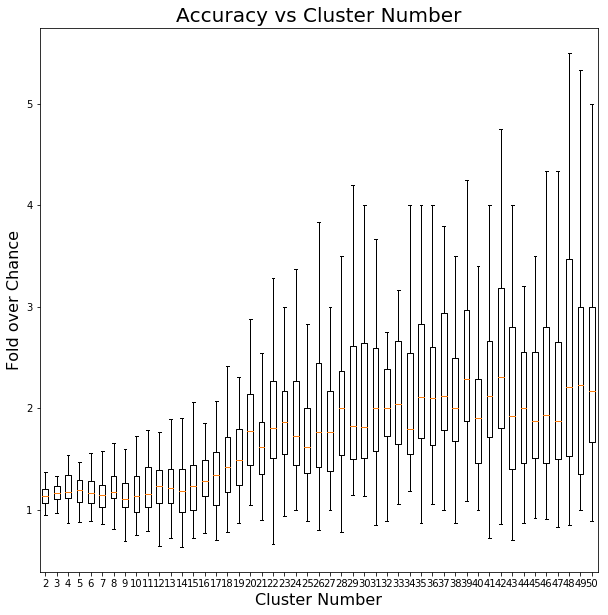

In [47]:
# accuracy
fold_over_chance = np.zeros((len(cluster_sizes), 50))

for ii,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [x/y for x, y in zip(acc, norm_acc)]
    fold_over_chance[ii,:] = foc
fold_over_chance.shape

plt.figure(figsize=(10,10))
plt.boxplot(fold_over_chance.T, labels = cluster_sizes, showfliers=False)
plt.xlabel('Cluster Number', fontsize=16)
plt.ylabel('Fold over Chance', fontsize=16)
plt.title('Accuracy vs Cluster Number', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/acc_vs_clusters_predictions.pdf')

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


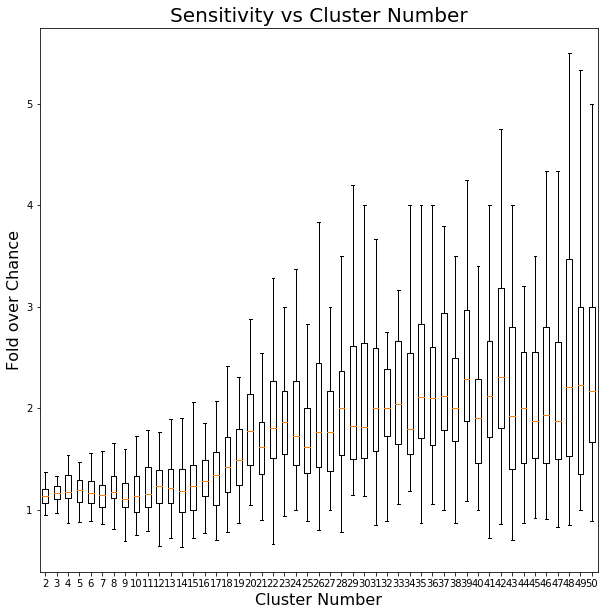

In [48]:
# sensitivity
fold_over_chance = np.zeros((len(cluster_sizes), 50))
for ii, c in enumerate(cluster_sizes):
    sensitivity_50 = []
    norm_sensitivity_50 = []
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)

    for x in all50mat:
        tp, tn, fp, fn = avg_statistics(x)
        sens = sensitivity(tp, fn)
        sensitivity_50.append(sens)
        
    for y in norm_all50mat:
        tp_n, tn_n, fp_n, fn_n = avg_statistics(y)
        norm_sens = sensitivity(tp_n, fn_n)
        norm_sensitivity_50.append(norm_sens)
    
    
    foc = [j/k for j,k in zip(sensitivity_50, norm_sensitivity_50)]
    fold_over_chance[ii, :] = foc
    
plt.figure(figsize=(10,10))
plt.boxplot(fold_over_chance.T, labels = cluster_sizes, showfliers=False)
plt.xlabel('Cluster Number', fontsize=16)
plt.ylabel('Fold over Chance', fontsize=16)
plt.title('Sensitivity vs Cluster Number', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/sens_vs_clusters_predictions.pdf')

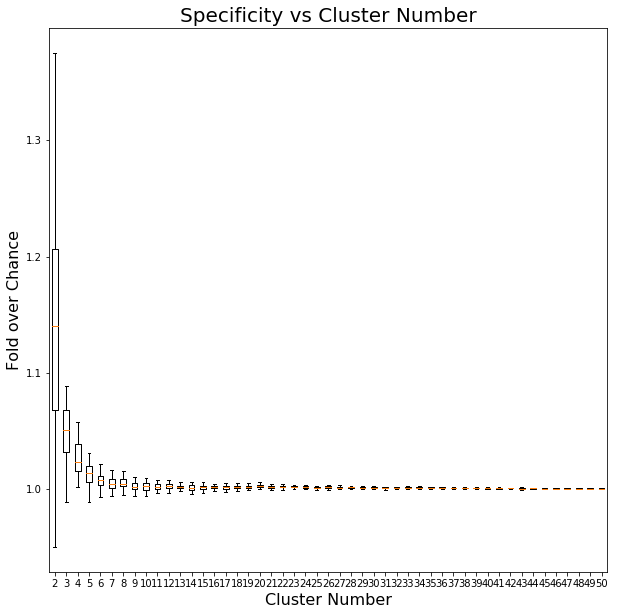

In [49]:
# specifity
fold_over_chance = np.zeros((len(cluster_sizes), 50))
for ii, c in enumerate(cluster_sizes):
    specificity_50 = []
    norm_specificity_50 = []
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)

    for x in all50mat:
        tp, tn, fp, fn = avg_statistics(x)
        spec = specificity(tn, fp)
        specificity_50.append(spec)
        
    for y in norm_all50mat:
        tp_n, tn_n, fp_n, fn_n = avg_statistics(y)
        norm_spec = specificity(tn_n, fp_n)
        norm_specificity_50.append(norm_spec)
    
    
    foc = [j/k for j,k in zip(specificity_50, norm_specificity_50)]
    fold_over_chance[ii, :] = foc
    
plt.figure(figsize=(10,10))
plt.boxplot(fold_over_chance.T, labels = cluster_sizes, showfliers=False)
plt.xlabel('Cluster Number', fontsize=16)
plt.ylabel('Fold over Chance', fontsize=16)
plt.title('Specificity vs Cluster Number', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/spec_vs_clusters_predictions.pdf')

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


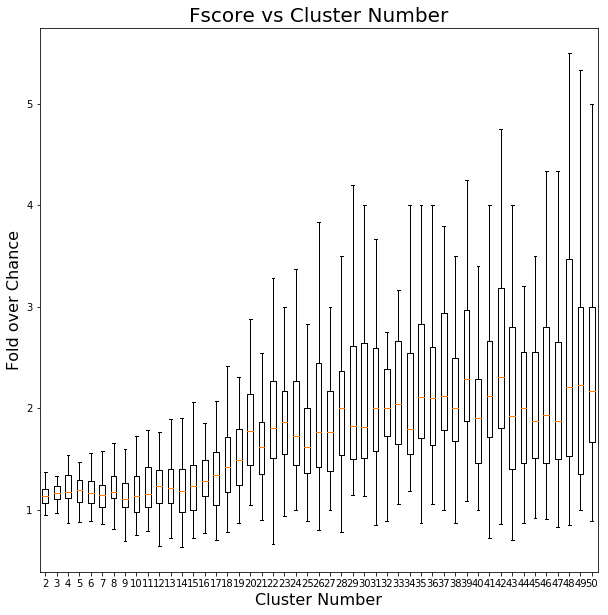

In [50]:
# fscore
fold_over_chance = np.zeros((len(cluster_sizes), 50))
for ii, c in enumerate(cluster_sizes):
    fscore_50 = []
    norm_fscore_50 = []
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)

    for x in all50mat:
        tp, tn, fp, fn = avg_statistics(x)
        f = fscore(tp, fp, fn)
        fscore_50.append(f)
        
    for y in norm_all50mat:
        tp_n, tn_n, fp_n, fn_n = avg_statistics(y)
        norm_f = fscore(tp_n, fp_n, fn_n)
        norm_fscore_50.append(norm_f)
    
    
    foc = [j/k for j,k in zip(fscore_50, norm_fscore_50)]
    fold_over_chance[ii, :] = foc
    
plt.figure(figsize=(10,10))
plt.boxplot(fold_over_chance.T, labels = cluster_sizes, showfliers=False)
plt.xlabel('Cluster Number',fontsize=16)
plt.ylabel('Fold over Chance', fontsize=16)
plt.title('Fscore vs Cluster Number', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/fscore_vs_clusters_predictions.pdf')